
1. drop_columns = ['funded_amnt_inv', 'out_prncp_inv'] 컬럼을 삭제해줬다.

2. 현재까지 가장 좋은 성능을 보이는 parameter + threshold = 0.4
ensemble_stacking
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=15,
                                  num_leaves =150)

3. robust scaler 사용 -> 사용전보다 0.004가 올랐다.

4. oversampling 시도해봤으나 성능이 오히려 떨어졌다.

5. 1로 예측한 비율이 train 데이터의 비율과 비슷해야 더 좋은 성능을 보였다.(0.37)

6. histgradientboostingclassifier final estimate 함수로 쓰면 더좋다고 해서 써봤지만, 별다른 성능향상을 보진 못했다.


현재 모델
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=10,
                                  num_leaves =120)


stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf),('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier(), stack_method = 'predict_proba')

In [2]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn

# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

## 변수 설명
  - **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
  - **annual_inc** : 연 소득 (annual income)
  - **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
  - **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
  - **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
  - **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
  - **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
  - **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
  - **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
  - **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
  - **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
  - **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
  - **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
  - **delinq_amnt** : 체납 금액 (delinquency amount)
  - **tax_liens** : 세금 저당권의 수 (Number of tax liens)
  - **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
  - **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
  - **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
  - **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
  - **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
  - **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
  - **funded_amnt** : 대출액 (Funded amount)
  - **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
  - **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
  - **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
  - **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
  - **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
  - **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
  - **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
  - **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
  - **total_rec_int** : 이자 상환액 (Interest received to date)
  - **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
  - **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
  - **depvar** : 고객의 부도 여부 (dependent variable)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220126_DAY27(1주차 모의경진대회)/train.csv')
df.head(10)

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1
5,0.1318,90000.0,3.48,7,0,0,2903,31,0,0,0,19548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7000,7000.0,0.0,1,7,236.47,0.854,0.0,0.0,1330.30,660,664,0
6,0.0791,60000.0,17.34,0,0,0,20399,35,0,0,0,117320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,20000,20000.0,0.0,1,18,625.90,0.369,0.0,0.0,2567.44,750,754,0
7,0.0975,79600.0,15.97,3,0,1,6481,17,0,0,0,18757,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,23800,23800.0,0.0,1,7,765.17,0.745,0.0,0.0,3006.76,680,684,0
8,0.0789,150000.0,7.36,1,0,0,15827,38,0,0,543,367504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,16000,16000.0,0.0,1,19,500.58,0.334,0.0,0.0,1286.38,665,669,0
9,0.0999,95000.0,25.78,0,1,0,17870,37,0,0,0,273776,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,24,258.10,0.764,0.0,0.0,796.59,665,669,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  int64  
 7   total_acc                   100000 non-null  int64  
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  int64  
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

In [5]:
df.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.130833,7.436061e+04,18.514508,0.343700,0.668880,0.235720,16090.202820,24.675910,0.018810,0.005800,250.588120,1.305281e+05,0.009630,19.288330,0.063820,0.065400,0.326240,0.089410,0.08058,0.059480,0.060710,0.046640,0.045320,0.045690,0.038570,0.075550,0.066410,0.000330,0.466120,0.000070,0.000050,0.110880,0.422550,0.321800,0.390200,0.288000,0.009620,0.226720,0.582810,0.0,0.060400,0.004250,0.019830,0.01101,0.007310,0.058200,0.000650,0.011250,0.007070,0.000880,0.434430,0.565570,0.489320,0.052360,0.060090,0.045700,0.050750,0.048560,0.051340,0.053430,0.048960,0.050030,0.049460,13735.317750,13729.341073,2.448885e+00,0.855920,11.620700,434.077648,0.537233,0.253327,0.253259,2491.282802,692.630550,696.630660,0.325690
std,0.044773,7.467409e+04,8.413049,0.905007,0.952044,0.661468,21569.939271,11.883834,0.150321,0.083585,2042.770881,1.503326e+05,0.110079,893.304366,0.468027,0.247232,0.468839,0.285336,0.27219,0.236522,0.238799,0.210868,0.208006,0.208813,0.192569,0.264278,0.248999,0.018163,0.498853,0.008366,0.007071,0.313985,0.493968,0.467169,0.487797,0.452833,0.097609,0.418712,0.493097,0.0,0.238228,0.065054,0.139417,0.10435,0.085186,0.234122,0.025487,0.105468,0.083786,0.029652,0.495684,0.495684,0.499888,0.222753,0.237655,0.208835,0.219488,0.214947,0.220691,0.224891,0.215786,0.218008,0.216828,8464.825314,8461.694483,1.489496e+01,0.351173,5.458774,265.921746,0.239373,18.053290,18.051746,2706.262200,29.668017,29.668584,0.468634
min,0.053200,5.360000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,

In [6]:
# 결측치 확인 -> 결측치 0
pd.DataFrame(df.isnull().sum()).rename(columns={0:'Non-Null Count'}).T

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
Non-Null Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [30]:
# 라벨(depvar) 비율 확인
print('y=1 ratio :', df.depvar.sum()/len(df))

y=1 ratio : 0.32569


# 데이터 전처리


In [31]:
X['emp_length2'] = X['emp_length2'].replace([1],2)
X['emp_length3'] = X['emp_length3'].replace([1],3)
X['emp_length4'] = X['emp_length4'].replace([1],4)
X['emp_length5'] = X['emp_length5'].replace([1],5)
X['emp_length6'] = X['emp_length6'].replace([1],6)
X['emp_length7'] = X['emp_length7'].replace([1],7)
X['emp_length8'] = X['emp_length8'].replace([1],8)
X['emp_length9'] = X['emp_length9'].replace([1],9)
X['emp_length10'] = X['emp_length10'].replace([1],10)
X['emp_length11'] = X['emp_length11'].replace([1],11)
X['emp_length12'] = X['emp_length12'].replace([1],12)

drop_columns = ['emp_length1','emp_length2','emp_length3','emp_length4','emp_length5','emp_length6','emp_length7','emp_length8','emp_length9', 'emp_length10', 'emp_length11', 'emp_length12']

X['emp_length'] = X.loc[:,drop_columns].sum(axis=1)
print(X['emp_length'].value_counts())

X = X.drop(columns= drop_columns, axis=1)

2     32624
3      8941
4      8058
11     7555
12     6641
1      6540
6      6071
5      5948
7      4664
9      4569
8      4532
10     3857
Name: emp_length, dtype: int64


In [32]:
drop_columns = ['home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6']

X['home_ownership2'] = X['home_ownership2'].replace([1],2)
X['home_ownership3'] = X['home_ownership3'].replace([1],3)
X['home_ownership4'] = X['home_ownership4'].replace([1],4)
X['home_ownership5'] = X['home_ownership5'].replace([1],5)
X['home_ownership6'] = X['home_ownership6'].replace([1],6)

X['home_ownership'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['home_ownership'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    46612
6    42255
5    11088
1       33
3        7
4        5
Name: home_ownership, dtype: int64


In [33]:
drop_columns = ['verification_status1', 'verification_status2', 'verification_status3']

X['verification_status2'] = X['verification_status2'].replace([1],2)
X['verification_status3'] = X['verification_status3'].replace([1],3)


X['verification_status'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['verification_status'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    39020
1    32180
3    28800
Name: verification_status, dtype: int64


In [34]:
drop_columns = ['purpose1',
       'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7',
       'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12',
       'purpose13', 'purpose14']

X['purpose2'] = X['purpose2'].replace([1],2)
X['purpose3'] = X['purpose3'].replace([1],3)
X['purpose4'] = X['purpose4'].replace([1],4)
X['purpose5'] = X['purpose5'].replace([1],5)
X['purpose6'] = X['purpose6'].replace([1],6)
X['purpose7'] = X['purpose7'].replace([1],7)
X['purpose8'] = X['purpose8'].replace([1],8)
X['purpose9'] = X['purpose9'].replace([1],9)
X['purpose10'] = X['purpose10'].replace([1],10)
X['purpose11'] = X['purpose11'].replace([1],11)
X['purpose12'] = X['purpose12'].replace([1],12)
X['purpose13'] = X['purpose13'].replace([1],13)
X['purpose14'] = X['purpose14'].replace([1],14)


X['purpose'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['purpose'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

3     58281
2     22672
5      6040
10     5820
7      1983
12     1125
8      1101
1       962
9       731
13      707
6       425
14       88
11       65
Name: purpose, dtype: int64


In [35]:
drop_columns = ['initial_list_status1', 'initial_list_status2']

X['initial_list_status2'] = X['initial_list_status2'].replace([1],2)

X['initial_list_status'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['initial_list_status'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    56557
1    43443
Name: initial_list_status, dtype: int64


In [36]:
drop_columns = ['mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11']

X['mths_since_last_delinq2'] = X['mths_since_last_delinq2'].replace([1],2)
X['mths_since_last_delinq3'] = X['mths_since_last_delinq3'].replace([1],3)
X['mths_since_last_delinq4'] = X['mths_since_last_delinq4'].replace([1],4)
X['mths_since_last_delinq5'] = X['mths_since_last_delinq5'].replace([1],5)
X['mths_since_last_delinq6'] = X['mths_since_last_delinq6'].replace([1],6)
X['mths_since_last_delinq7'] = X['mths_since_last_delinq7'].replace([1],7)
X['mths_since_last_delinq8'] = X['mths_since_last_delinq8'].replace([1],8)
X['mths_since_last_delinq9'] = X['mths_since_last_delinq9'].replace([1],9)
X['mths_since_last_delinq10'] = X['mths_since_last_delinq10'].replace([1],10)
X['mths_since_last_delinq11'] = X['mths_since_last_delinq11'].replace([1],11)


X['mths_since_last_delinq'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['mths_since_last_delinq'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
X.columns # 삭제가 잘됬는지 확인

1     48932
3      6009
8      5343
2      5236
7      5134
5      5075
10     5003
11     4946
9      4896
6      4856
4      4570
Name: mths_since_last_delinq, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'emp_length',
       'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

In [37]:
drop_columns = ['out_prncp_inv', 'funded_amnt_inv'] 
# 'initial_list_status' -> 0.1270으로 하락
# 컬럼 제거 전 제거 후 0.1271로 설명력 유지
X = X.drop(columns=drop_columns, axis = 1)

# features

In [38]:
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
robustScaler.fit(X[X.columns])
X[X.columns] = robustScaler.transform(X[X.columns])

# Train Valid Split

In [39]:
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [40]:
# training set과 validation set의 데이터 수 확인
print('training set length :', len(X_train))
print('validation set length :', len(X_valid))

training set length : 80000
validation set length : 20000


In [41]:
# validation set의 라벨 비율 확인
y_valid.sum()/len(y_valid)

0.3279

In [42]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

# Ensemble(Stacking)


정확도: 0.7582
정밀도: 0.6688
재현율: 0.5204
AUC: 0.6974
F1: 0.5854


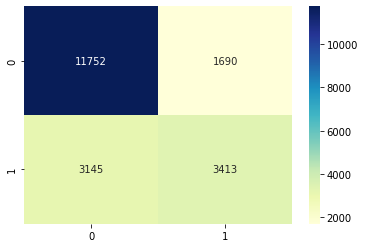

In [43]:
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=10,
                                  num_leaves =120)


stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf),('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier(), stack_method = 'predict_proba')
stacking_clf.fit(X_train, y_train)

y_pred_stack = stacking_clf.predict(X_valid)
y_pred_prob = stacking_clf.predict_proba(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

# 정확도: 0.7542
# 정밀도: 0.6658
# 재현율: 0.4971
# AUC: 0.6880
# F1: 0.5692


In [44]:
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve



y_prob2 = y_pred_prob[:,1]


fpr, tpr, thresholds = roc_curve(y_valid, y_prob2)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_pred_prob[:,1] >= best_thresh).astype(bool)
print(classification_report(y_valid, y_prob_pred, target_names=['normal', 'abnormal']))

Best Threshold=0.348954, sensitivity = 0.745, specificity = 0.726, J=0.471
              precision    recall  f1-score   support

      normal       0.85      0.73      0.78     13442
    abnormal       0.57      0.75      0.65      6558

    accuracy                           0.73     20000
   macro avg       0.71      0.74      0.72     20000
weighted avg       0.76      0.73      0.74     20000



threshold : 0.3

정확도: 0.7165
정밀도: 0.5472
재현율: 0.7838
AUC: 0.7337
F1: 0.6445
threshold : 0.35

정확도: 0.7323
정밀도: 0.5704
재현율: 0.7444
AUC: 0.7354
F1: 0.6459
threshold : 0.38

정확도: 0.7396
정밀도: 0.5855
재현율: 0.7046
AUC: 0.7306
F1: 0.6396
threshold : 0.4

정확도: 0.7440
정밀도: 0.5965
재현율: 0.6778
AUC: 0.7270
F1: 0.6345
threshold : 0.42

정확도: 0.7486
정밀도: 0.6097
재현율: 0.6478
AUC: 0.7227
F1: 0.6282
threshold : 0.43

정확도: 0.7500
정밀도: 0.6164
재현율: 0.6295
AUC: 0.7192
F1: 0.6229
threshold : 0.45

정확도: 0.7530
정밀도: 0.6283
재현율: 0.6045
AUC: 0.7150
F1: 0.6161
threshold : 0.48

정확도: 0.7560
정밀도: 0.6477
재현율: 0.5615
AUC: 0.7062
F1: 0.6015


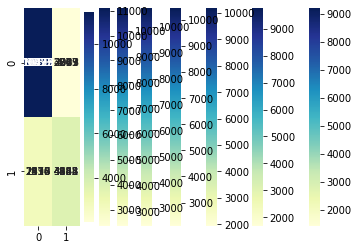

In [46]:
for i in [0.3, 0.35, 0.38, 0.4, 0.42, 0.43, 0.45, 0.48] :
  print(f'threshold : {i}')
  get_clf_eval(y_valid, y_pred_prob[:,1]>i) 


# 결과 출력

In [47]:

submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220126_DAY27(1주차 모의경진대회)/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220126_DAY27(1주차 모의경진대회)/test.csv')

In [48]:
df_test['emp_length2'] = df_test['emp_length2'].replace([1],2)
df_test['emp_length3'] = df_test['emp_length3'].replace([1],3)
df_test['emp_length4'] = df_test['emp_length4'].replace([1],4)
df_test['emp_length5'] = df_test['emp_length5'].replace([1],5)
df_test['emp_length6'] = df_test['emp_length6'].replace([1],6)
df_test['emp_length7'] = df_test['emp_length7'].replace([1],7)
df_test['emp_length8'] = df_test['emp_length8'].replace([1],8)
df_test['emp_length9'] = df_test['emp_length9'].replace([1],9)
df_test['emp_length10'] = df_test['emp_length10'].replace([1],10)
df_test['emp_length11'] = df_test['emp_length11'].replace([1],11)
df_test['emp_length12'] = df_test['emp_length12'].replace([1],12)

drop_columns = ['emp_length1','emp_length2','emp_length3','emp_length4','emp_length5','emp_length6','emp_length7','emp_length8','emp_length9', 'emp_length10', 'emp_length11', 'emp_length12']

df_test['emp_length'] = df_test.loc[:,drop_columns].sum(axis=1)
print(df_test['emp_length'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1)

2     11574
3      3286
4      2849
11     2702
12     2357
1      2301
6      2156
5      2128
9      1709
7      1687
8      1641
10     1426
Name: emp_length, dtype: int64


In [49]:
drop_columns = ['home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6']

df_test['home_ownership2'] = df_test['home_ownership2'].replace([1],2)
df_test['home_ownership3'] = df_test['home_ownership3'].replace([1],3)
df_test['home_ownership4'] = df_test['home_ownership4'].replace([1],4)
df_test['home_ownership5'] = df_test['home_ownership5'].replace([1],5)
df_test['home_ownership6'] = df_test['home_ownership6'].replace([1],6)

df_test['home_ownership'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['home_ownership'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    16792
6    15054
5     3957
1        9
4        2
3        2
Name: home_ownership, dtype: int64


In [50]:
drop_columns = ['verification_status1', 'verification_status2', 'verification_status3']

df_test['verification_status2'] = df_test['verification_status2'].replace([1],2)
df_test['verification_status3'] = df_test['verification_status3'].replace([1],3)


df_test['verification_status'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['verification_status'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    14020
1    11473
3    10323
Name: verification_status, dtype: int64


In [51]:
drop_columns = ['purpose1',
       'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7',
       'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12',
       'purpose13', 'purpose14']

df_test['purpose2'] = df_test['purpose2'].replace([1],2)
df_test['purpose3'] = df_test['purpose3'].replace([1],3)
df_test['purpose4'] = df_test['purpose4'].replace([1],4)
df_test['purpose5'] = df_test['purpose5'].replace([1],5)
df_test['purpose6'] = df_test['purpose6'].replace([1],6)
df_test['purpose7'] = df_test['purpose7'].replace([1],7)
df_test['purpose8'] = df_test['purpose8'].replace([1],8)
df_test['purpose9'] = df_test['purpose9'].replace([1],9)
df_test['purpose10'] = df_test['purpose10'].replace([1],10)
df_test['purpose11'] = df_test['purpose11'].replace([1],11)
df_test['purpose12'] = df_test['purpose12'].replace([1],12)
df_test['purpose13'] = df_test['purpose13'].replace([1],13)
df_test['purpose14'] = df_test['purpose14'].replace([1],14)


df_test['purpose'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['purpose'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

3     20956
2      7897
5      2189
10     2104
7       748
8       421
1       371
12      370
9       307
13      246
6       153
14       32
11       22
Name: purpose, dtype: int64


In [52]:
drop_columns = ['initial_list_status1', 'initial_list_status2']

df_test['initial_list_status2'] = df_test['initial_list_status2'].replace([1],2)

df_test['initial_list_status'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['initial_list_status'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    20245
1    15571
Name: initial_list_status, dtype: int64


In [53]:
drop_columns = ['mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11']

df_test['mths_since_last_delinq2'] = df_test['mths_since_last_delinq2'].replace([1],2)
df_test['mths_since_last_delinq3'] = df_test['mths_since_last_delinq3'].replace([1],3)
df_test['mths_since_last_delinq4'] = df_test['mths_since_last_delinq4'].replace([1],4)
df_test['mths_since_last_delinq5'] = df_test['mths_since_last_delinq5'].replace([1],5)
df_test['mths_since_last_delinq6'] = df_test['mths_since_last_delinq6'].replace([1],6)
df_test['mths_since_last_delinq7'] = df_test['mths_since_last_delinq7'].replace([1],7)
df_test['mths_since_last_delinq8'] = df_test['mths_since_last_delinq8'].replace([1],8)
df_test['mths_since_last_delinq9'] = df_test['mths_since_last_delinq9'].replace([1],9)
df_test['mths_since_last_delinq10'] = df_test['mths_since_last_delinq10'].replace([1],10)
df_test['mths_since_last_delinq11'] = df_test['mths_since_last_delinq11'].replace([1],11)


df_test['mths_since_last_delinq'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['mths_since_last_delinq'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
df_test.columns # 삭제가 잘됬는지 확인

1     17595
3      2090
2      1949
7      1861
11     1861
5      1825
8      1768
6      1731
9      1721
4      1711
10     1704
Name: mths_since_last_delinq, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'ID',
       'emp_length', 'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

In [54]:
drop_columns = ['funded_amnt_inv', 'out_prncp_inv']
df_test = df_test.drop(columns = drop_columns, axis=1)

In [55]:
df_test = df_test.drop(columns=['ID'])
df_test[df_test.columns] = robustScaler.transform(df_test[df_test.columns])

In [56]:
df_test

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq
0,0.289256,-1.013778,0.650446,0.0,0.0,1.0,-0.557572,-0.866667,0.0,0.0,0.0,-0.351478,0.0,0.0,0.0,-0.325000,0.00,0.0,-1.166667,-0.261021,-0.640669,0.0,-0.529264,0.428571,0.428571,0.500000,0.25,-0.5,0.0,0.0,-0.166667
1,1.033058,0.066667,-0.331711,0.0,0.0,0.0,1.054948,-0.200000,0.0,0.0,0.0,0.284415,0.0,0.0,0.0,0.666667,0.00,-1.0,-0.166667,0.453977,0.958217,0.0,1.490277,-0.285714,-0.285714,-0.333333,-0.75,0.0,0.0,0.0,0.833333
2,-0.371901,-0.200000,0.423358,0.0,0.0,0.0,-0.008905,-0.133333,0.0,0.0,0.0,-0.209218,0.0,0.0,0.0,-0.166667,16.25,0.0,-0.666667,-0.123343,0.108635,0.0,-0.075212,-0.285714,-0.285714,1.166667,0.25,0.0,0.0,0.0,0.833333
3,0.798347,0.217778,0.994323,0.0,0.0,0.0,2.320043,0.200000,0.0,0.0,0.0,0.504967,0.0,0.0,0.0,1.266667,0.00,-1.0,0.833333,0.947619,0.445682,0.0,2.499264,-0.571429,-0.571429,-0.333333,-0.75,0.5,0.0,0.0,-0.166667
4,1.233058,-0.266667,0.612328,0.0,2.0,0.0,0.788744,0.066667,0.0,0.0,0.0,0.401973,0.0,0.0,0.0,0.833333,0.00,-1.0,0.333333,0.652477,0.225627,0.0,2.813721,0.714286,0.714286,-0.333333,-0.75,0.0,-1.0,-1.0,-0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35811,-0.371901,1.066667,-0.733171,0.0,0.0,1.0,-0.150728,0.666667,0.0,0.0,0.0,-0.302147,0.0,0.0,0.0,0.000000,0.00,0.0,0.333333,0.070358,-0.543175,0.0,-0.095805,-0.571429,-0.571429,-0.333333,-0.75,-0.5,0.0,0.0,-0.166667
35812,-0.743802,-0.377778,1.175994,1.0,0.0,0.0,0.734277,0.400000,0.0,0.0,0.0,-0.258315,0.0,0.0,0.0,-0.583333,0.00,0.0,-0.333333,-0.623213,0.415042,0.0,-0.513085,0.571429,0.571429,-0.500000,0.25,0.0,-1.0,0.0,0.166667
35813,0.155372,-0.288889,-0.037307,0.0,0.0,0.0,-0.401559,-1.066667,0.0,0.0,0.0,-0.282885,0.0,0.0,0.0,-0.500000,0.00,0.0,-0.666667,-0.483450,-0.579387,0.0,-0.119212,0.571429,0.571429,-0.166667,0.25,-0.5,-1.0,-1.0,-0.166667
35814,-0.223140,0.507822,-0.656934,0.0,0.0,1.0,-0.284273,-0.666667,0.0,0.0,0.0,-0.218906,0.0,0.0,0.0,-0.166667,0.00,0.0,-0.500000,-0.110648,-0.526462,0.0,-0.000005,1.142857,1.142857,-0.166667,0.25,-0.5,0.0,0.0,-0.166667


# Submission

In [65]:
# 제출 양식 다운로드

y_pred_prob = stacking_clf.predict_proba(df_test)
submit['answer'] = y_pred_prob[:,1] > 0.40
submit['answer'] = submit['answer'].astype('int')

print(sum(submit['answer'])/len(submit['answer']))

0.3727105204377932


In [63]:
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/20220207_DAY39/prediction8.csv', index=False)